<a href="https://colab.research.google.com/github/grayhacked/AI/blob/main/recsys_TP1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender systems: Memory-Based Collaborative Filtering

Dataset: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

This dataset contains a real sample of **12 months logs (Mar. 2016 - Feb. 2017)** from CI&T's Internal Communication platform (DeskDrop) corresponding to about **73k logged users interactions** on more than **3k public articles** shared in the platform.

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm

## Load data

In [ ]:
%%capture
!wget "https://github.com/eishkina-estia/ML2023/raw/main/data/CI&T DeskDrop.zip"
!unzip "CI&T DeskDrop.zip"

In [ ]:
interactions_df = pd.read_csv('/content/CI&T DeskDrop/users_interactions.csv')
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [ ]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)

In [ ]:
nb_articles = len(interactions_df['contentId'].unique())
nb_users = len(interactions_df['personId'].unique())

print(f'Distinct articles: \t{nb_articles}')
print(f'Distinct users: \t{nb_users}')

Distinct articles: 	2987
Distinct users: 	1895


## Data preprocessing

There are different types of interactions (`eventType` column) logged in the dataset:

* `VIEW`: The user opened the article.
* `LIKE`: The user liked the article.
* `COMMENT CREATED`: The user created a comment in the article.
* `FOLLOW`: The user chose to be notified on any new comment in the article.
* `BOOKMARK`: The user bookmarked the article for easy return in the future.

We need to get some integrated quantitative measure to represent the interaction between a user and an article (an item).

Do the following preprocessing:

* Encode interaction types with numbers:
  * `VIEW`: `1.0`
  * `LIKE`: `2.0`
  * `COMMENT CREATED`: `2.5`
  * `FOLLOW`: `3.0`
  * `BOOKMARK`: `4.0`

* For each tuple (user, article) calculate:
  * base-2 logarithm of 1 plus the sum of all the numeric representations of the corresponding interactions,
  * timestamp corresponding to the last interaction.

* Keep in the dataset only those users who interacted with at least 5 articles (i.e. remove "cold" users). Display the percentage of dropped rows.

* Encapsulate all the previous steps in a function to be able to easily replace the logic if needed.

### Encode interaction types with numbers

In [ ]:
interactions_df['eventType'].value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

In [ ]:
interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

### Merge different interactions for each `<user,article>` pair

In [ ]:
interactions_df = (
    interactions_df
    .groupby(['personId', 'contentId']).agg(
        eventStrength=('eventStrength', lambda x: np.log2(x.sum()+1)),
        last_timestamp=('timestamp', 'max')
    ).reset_index()
)

interactions_df

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994342
...,...,...,...,...
40705,998688566268269815,-401664538366009049,1.000000,1474567449
40706,998688566268269815,3456674717452933449,2.584963,1478802088
40707,998688566268269815,6881796783400625893,1.000000,1474567675
40708,998688566268269815,7174452660053929140,2.321928,1478812905


### Remove "cold" users

In [ ]:
users_interactions_count = interactions_df.groupby('personId').size()
users_interactions_count

personId
-1007001694607905623      6
-1032019229384696495    648
-108842214936804958     270
-1093393486211919385      2
-1110220372195277179      3
                       ... 
987030274299018507        3
989049974880576288       19
98958074799194811         4
997469202936578234       17
998688566268269815        6
Length: 1895, dtype: int64

In [ ]:
threshold_non_cold_users = 5

users_interactions_count_non_cold = users_interactions_count[users_interactions_count >= threshold_non_cold_users]
interactions_non_cold = interactions_df.loc[np.in1d(interactions_df.personId, users_interactions_count_non_cold.index)]

nb_users = len(users_interactions_count)
nb_users_non_cold = len(users_interactions_count_non_cold)

nb_ratings = len(interactions_df)
nb_ratings_non_cold_users = len(interactions_non_cold)

print(f'number of users: {nb_users}')
print(f'number of ratings (<user,item> pairs): {nb_ratings}')
print()

print(f'number of users with at least {threshold_non_cold_users} interactions: {nb_users_non_cold} ({nb_users_non_cold*100/nb_users:.1f}%)')
print(f'number of ratings (<user,item> pairs) for users with at least {threshold_non_cold_users} interactions: {nb_ratings_non_cold_users} ({nb_ratings_non_cold_users*100/nb_ratings:.1f}%)')

number of users: 1895
number of ratings (<user,item> pairs): 40710

number of users with at least 5 interactions: 1140 (60.2%)
number of ratings (<user,item> pairs) for users with at least 5 interactions: 39106 (96.1%)


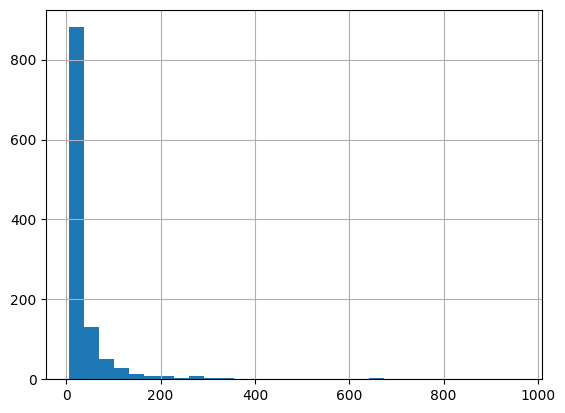

In [ ]:
# users_interactions_count_df.hist(bins=30);
users_interactions_count_non_cold.hist(bins=30);

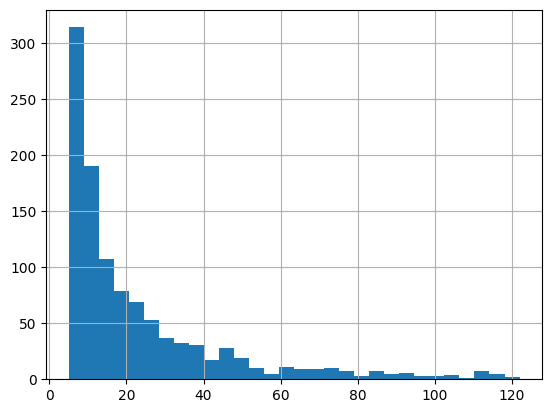

In [ ]:
users_interactions_count_non_cold[users_interactions_count_non_cold<users_interactions_count_non_cold.quantile(.95)].hist(bins=30);

## Modeling

* Split data into train (75%) and test (25%) sets by timestamp.
* Implement collaborative filtering on train data:
  * user based
  * pearson similarity
* Evaluate the model on test data using the mean precision@10.
* Apply SVD algorithm, evaluate the results, and compare them with those got with simple collaborative filtering.

### Split data

In [ ]:
def train_test_split(data, user_col, item_col, rating_col, time_col, test_size=0.25):

    # sort data by time: test data must correspond to the period which is after the period of train data
    data = data.sort_values(by=[time_col])

    users = data[user_col].unique()
    train_size = 1 - test_size
    X_train_users, X_test_users, y_train_users, y_test_users = [], [], [], []

    # tqdm displays a progress bar
    for user in tqdm(users, desc='users'):
      # get data only for a given user
      cur_user = data[data[user_col] == user]
      # index to split data by user
      idx = int(len(cur_user) * train_size)
      X_train_users.append(cur_user[[user_col, item_col]].iloc[:idx, :].values)
      X_test_users.append(cur_user[[user_col, item_col]].iloc[idx:, :].values)
      y_train_users.append(cur_user[rating_col].values[:idx])
      y_test_users.append(cur_user[rating_col].values[idx:])

    # stack data
    X_train = pd.DataFrame(np.vstack(X_train_users), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_users), columns=[user_col, item_col])
    y_train = pd.Series(np.hstack(y_train_users), name=rating_col)
    y_test = pd.Series(np.hstack(y_test_users), name=rating_col)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    interactions_non_cold, test_size=0.25,
    user_col='personId', item_col='contentId',
    rating_col='eventStrength', time_col='last_timestamp')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

users:   0%|          | 0/1140 [00:00<?, ?it/s]

((28869, 2), (10237, 2), (28869,), (10237,))

For each user (`personId`) prepare list of train and test items (`contentId`).

### User-user collaborative filtering

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

class CollaborativeFiltering(BaseEstimator):

    sim_methods = ['cosine', 'pearson']

    def __init__(self, sim_method="cosine", user_based=False):

        BaseEstimator.__init__(self)

        if sim_method not in self.sim_methods:
            raise ValueError(f"Bad value for sim_method: only {self.sim_methods} methods are supported")

        self.sim_method = sim_method
        self.user_based = user_based
        return

    def fit(self, X, y, user_col='userId', item_col='movieId'):

        X = X.copy()

        # add target as column to X
        X['y'] = y

        self.users = X[user_col].unique()
        self.items = X[item_col].unique()

        if self.user_based:
            # users x items matrix
            row_dim = user_col
            col_dim = item_col
        else:
            # items x users matrix
            row_dim = item_col
            col_dim = user_col

        # calculate the average rating by user or by item
        self.mean_y = X.groupby(row_dim)['y'].mean()
        # for each user subtract from the rating their average rating
        X['y_centered'] = X['y'] - X[row_dim].apply(lambda x: self.mean_y[x])

        # create user-item matrix with (transformed) ratings
        # users by rows and items by columns
        # replace missing values with 0
        self.ratings_matrix = pd.pivot_table(X, values='y', index=row_dim, columns=col_dim, fill_value=0)
        self.ratings_matrix_centered = pd.pivot_table(X, values='y_centered', index=row_dim, columns=col_dim, fill_value=0)

        if self.user_based:
            # users x items matrix
            raw_ids_users = self.ratings_matrix.index
            raw_ids_items = self.ratings_matrix.columns
        else:
            # items x users matrix
            raw_ids_users = self.ratings_matrix.columns
            raw_ids_items = self.ratings_matrix.index

        # create dictionaries for users and items { raw id: inner id (index) in ratings }
        self.users_inner_id = dict()
        for user in self.users:
            self.users_inner_id[user] = raw_ids_users.get_loc(user)

        self.items_inner_id = dict()
        for item in self.items:
            self.items_inner_id[item] = raw_ids_items.get_loc(item)

        # convert from pd.DataFrame to numpy matrix: computing optimization
        self.ratings_matrix = self.ratings_matrix.values
        self.ratings_matrix_centered = self.ratings_matrix_centered.values

        # calculate the pairwise similarities between all samples (rows) in ratings matrix.
        if self.sim_method == 'cosine':
            self.sim_matrix = cosine_similarity(self.ratings_matrix)
        elif self.sim_method == 'pearson':
            # The Pearson correlation coefficient can be seen as a mean-centered cosine similarity,
            self.sim_matrix = cosine_similarity(self.ratings_matrix_centered)
            # self.sim_matrix = np.nan_to_num(np.corrcoef(self.ratings_matrix))

        return self

    def predict_rating(self, user, item, sim_threshhold=None):

        # return 0 for unknown users and items
        if item not in self.items or user not in self.users:
            return 0

        # cur_user_inner_id = self.users_inner_id[user]
        # cur_item_inner_id = self.items_inner_id[user]

        if self.user_based:
            # users x items matrix
            row_inner_id = self.users_inner_id[user]
            col_inner_id = self.items_inner_id[item]
            mean_rating = self.mean_y[user]
        else:
            # items x users matrix
            row_inner_id = self.items_inner_id[item]
            col_inner_id = self.users_inner_id[user]
            mean_rating = self.mean_y[item]

        sim_coefs = self.sim_matrix[row_inner_id]
        neighbours_inner_id = np.arange(len(sim_coefs))

        # don't consider the user themselves as neighbours
        neighbours_inner_id = np.delete(neighbours_inner_id, row_inner_id)
        sim_coefs = np.delete(sim_coefs, row_inner_id)

        if sim_threshhold is not None:
            neighbours_inner_id = np.where(sim_coefs > sim_threshhold)[0]
            sim_coefs = sim_coefs[neighbours_inner_id]

        # get neighbours ratings
        # neighbours_ratings = self.ratings_matrix[neighbours_inner_id, col_inner_id]
        neighbours_ratings = self.ratings_matrix_centered[neighbours_inner_id, col_inner_id]

        # calculate numerator and denominator from rating estimation formula
        numerator = sim_coefs.dot(neighbours_ratings)
        denominator = np.abs(sim_coefs).sum()

        if denominator == 0:
            prediction = mean_rating
        else:
            prediction = mean_rating + numerator / denominator

        return prediction

    def predict(self, X, user_col='userId', item_col='movieId', sim_threshhold=None):
        # y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[user_col], row[item_col], sim_threshhold), axis=1)
        X_np = X[[user_col, item_col]].values
        i = 0
        y = np.zeros(len(X_np))
        for row in tqdm(X_np, desc='Predictions'):
            y[i] = self.predict_rating(row[0], row[1], sim_threshhold)
            i += 1
        return y

In [ ]:
%%time
print('start fitting...')
ubcf = CollaborativeFiltering(sim_method='pearson', user_based=True)
ubcf.fit(X_train, y_train, user_col='personId', item_col='contentId')

print('start predicting...')
y_pred = ubcf.predict(X_test, user_col='personId', item_col='contentId')
rmse_score = mean_squared_error(y_test, y_pred, squared=False)
print(f'rmse = {rmse_score:.2f}')

start fitting...
start predicting...


Predictions:   0%|          | 0/10237 [00:00<?, ?it/s]

rmse = 0.90
CPU times: user 3.67 s, sys: 197 ms, total: 3.86 s
Wall time: 3.75 s


### Evaluation

Metric to use is the mean precision@10.

In [ ]:
users = X_train['personId'].unique()
items = X_train['contentId'].unique()
len(users) * len(items)

3090540

#### Example for user 0

In [ ]:
items_user0_viewed = X_train[X_train['personId'] == users[0]]['contentId'].values
items_user0_non_viewed = items[~np.isin(items, items_user0_viewed)]
len(items), len(items_user0_viewed), len(items_user0_non_viewed)

(2711, 259, 2452)

In [ ]:
X_test_user0 = pd.DataFrame(items_user0_non_viewed, columns=['contentId'])
X_test_user0['personId'] = users[0]
X_test_user0

,contentId,personId
0,-5170198873410718233,692689608292948411
1,-5781461435447152359,692689608292948411
2,-8208801367848627943,692689608292948411
3,-5150441845583002912,692689608292948411
4,-6074646493203713780,692689608292948411
...,...,...
2447,-7358932766266901263,692689608292948411
2448,8424505741986577894,692689608292948411
2449,-72844094766108869,692689608292948411
2450,5111115201913219115,692689608292948411


In [ ]:
y_pred_user0 = ubcf.predict(X_test_user0, user_col='personId', item_col='contentId')
y_pred_user0

Predictions:   0%|          | 0/2452 [00:00<?, ?it/s]

array([1.37004849, 1.36591074, 1.3465147 , ..., 1.36965418, 1.36965418,
       1.36965418])

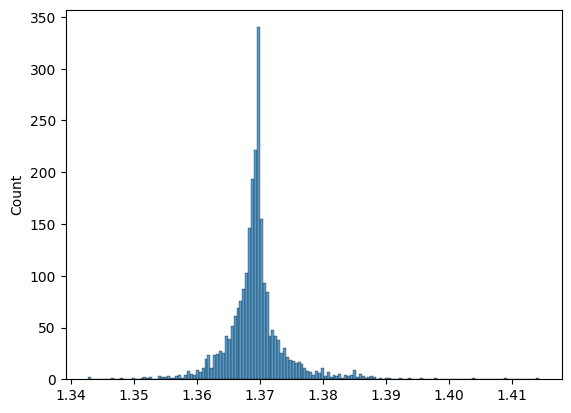

In [ ]:
import seaborn as sns

sns.histplot(y_pred_user0);

In [ ]:
k = 10
y_pred_user0 = pd.Series(y_pred_user0, name='rating')
rating_pred_user0 = pd.concat([X_test_user0, y_pred_user0], axis=1)
R_u_k_user0 = rating_pred_user0.sort_values('rating', ascending=False)[:k]['contentId'].to_numpy()
R_u_k_user0

array(['2372438485070148864', '6062146090334604102',
       '2285214528595997209', '3269302169678465882',
       '-5014627593450767720', '-4228415104574264137',
       '8901449108040307914', '-5625593730080264433',
       '-820343972901090172', '4118743389464105405'], dtype=object)

In [ ]:
L_u_user0 = items_user0_viewed
L_u_user0

array(['8078873160882064481', '7528802258213768379',
       '-6133746337603876146', '-2711301039947937868',
       '8471417198703153120', '6652210819857467321',
       '-8287402887944984163', '3475346635930218065',
       '8095004770374551394', '1964631817676172382',
       '5333141914314968598', '3193164045772142182',
       '-9083294960368598209', '3067875254349597654',
       '2313825045587317872', '-9100490342054218852',
       '-1024046541613287684', '3068975614432538771',
       '5317978293082383492', '4814419120794996930',
       '2900029983899283273', '1674373276159762025',
       '5145921881592486583', '809601605585939618',
       '-1672166631728511207', '5274322067107287523',
       '-6151852268067518688', '-4102297002729307038',
       '-8248141950199177506', '4579557799493615039',
       '3057455921237571253', '-7681408188643141872',
       '-1926525896637230556', '-6863138929434705713',
       '3262563792577344354', '4555339116751579515',
       '3382511589554885024', '519

In [ ]:
R_and_L_user0 = np.intersect1d(R_u_k_user0, L_u_user0)
print(R_and_L_user0)
precision_at_k_user0 = len(R_and_L_user0) / len(R_u_k_user0)
precision_at_k_user0

[]


0.0

#### Implementation for all users

In [ ]:
import itertools

# all possible permutations
X_test_all = pd.DataFrame(itertools.product(users,items), columns=['personId','contentId'])

# remove those from train set
print(len(X_test_all))
print(len(X_test_all) - len(X_train))
X_test_all = X_test_all.set_index(['personId','contentId'])
X_test_all = X_test_all.drop(X_train.set_index(['personId','contentId']).index)
print(len(X_test_all))
X_test_all = X_test_all.reset_index()

3090540
3061671
3061671


In [ ]:
%%time
y_pred_all = ubcf.predict(X_test_all, user_col='personId', item_col='contentId')

Predictions:   0%|          | 0/3061671 [00:00<?, ?it/s]

CPU times: user 13min 26s, sys: 4.9 s, total: 13min 31s
Wall time: 14min 27s


In [ ]:
# convert from numpy array to pandas series (vector)
y_pred_all = pd.Series(data=y_pred_all, name='rating')

In [ ]:
def mean_precision_at_k(X_pred, y_pred, X_test, y_test, user_col, item_col, k=10):

    data_pred = pd.concat([X_pred[[user_col, item_col]], y_pred.rename('rating')], axis=1)
    data_test = pd.concat([X_test[[user_col, item_col]], y_test.rename('rating')], axis=1)

    users = data_test[user_col].unique()

    # sort predicted ratings
    data_pred = data_pred.sort_values('rating', ascending=False)

    precision_by_user = np.zeros(len(users))
    i = 0

    for u in tqdm(users, desc='users'):
        R_u_k = data_pred.loc[data_pred[user_col] == u, item_col][:10]
        L_u = data_test.loc[data_test[user_col] == u, item_col]
        if len(R_u_k) != 0:
            precision_by_user[i] = sum(np.isin(R_u_k, L_u)) / len(R_u_k)
        i += 1

    precision_by_user = pd.Series(data=precision_by_user, index=users)
    mean_precision = np.mean(precision_by_user)

    return mean_precision, precision_by_user

In [ ]:
%%time
mean_precision, precision_by_user = mean_precision_at_k(X_test_all, y_pred_all, X_test, y_test,
                                                        user_col='personId', item_col='contentId', k=10)

users:   0%|          | 0/1140 [00:00<?, ?it/s]

In [ ]:
mean_precision

0.010175438596491228

### Sunrise: SVD

In [ ]:
%%capture
!pip install surprise

In [ ]:
from surprise import Reader, Dataset

# A reader (parser) is needed only for the required rating_scale param.
rating_scale = tuple(interactions_non_cold.eventStrength.agg(['min','max']))
reader = Reader(rating_scale=rating_scale)

interactions_non_cold = interactions_non_cold.sort_values('last_timestamp')
# The columns must correspond to user id, item id and ratings (in that order).
data_surprise = Dataset.load_from_df(interactions_non_cold[['personId','contentId','eventStrength']], reader)

In [ ]:
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_surprise, test_size=.25)

# We'll use the famous SVD algorithm.
# Hyperparameters:
# - default learning rate lr_all=0.005
# - default regularization term reg_all=0.02
svd = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
svd.fit(trainset)
predictions = svd.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.6435


0.6435436069717954

In [ ]:
# https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=precision_recall_at_k#how-to-compute-precision-k-and-recall-k
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [ ]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))


0.0
0.0


In [ ]:
# The goal is to use svd.test() on X_test_all

# The columns must correspond to user id, item id and ratings (in that order).
data_test_all_surprise = X_test_all
data_test_all_surprise['eventStrength'] = 0.0

data_surprise_all = Dataset.load_from_df(data_test_all_surprise, reader)

# https://surprise.readthedocs.io/en/stable/dataset.html?highlight=build_full_trainset#surprise.dataset.DatasetAutoFolds.build_full_trainset
# no split
trainset = data_surprise_all.build_full_trainset()
# https://surprise.readthedocs.io/en/stable/trainset.html?highlight=build_testset#surprise.Trainset.build_testset
# all data in test
testset = trainset.build_testset()

predictions = svd.test(testset)

In [ ]:
predictions[:3]

[Prediction(uid='692689608292948411', iid='-5170198873410718233', r_ui=0.0, est=1.1867935455462668, details={'was_impossible': False}),
 Prediction(uid='692689608292948411', iid='-5781461435447152359', r_ui=0.0, est=1.0, details={'was_impossible': False}),
 Prediction(uid='692689608292948411', iid='-8208801367848627943', r_ui=0.0, est=1.28076792727747, details={'was_impossible': False})]

In [ ]:
y_pred_all_svd = np.zeros(len(X_test_all))
i = 0

for _, _, _, est, _ in predictions:
    y_pred_all_svd[i] = est
    i += 1

y_pred_all_svd = pd.Series(y_pred_all_svd, name='rating')

In [ ]:
%%time
mean_precision_svd, precision_by_user_svd = mean_precision_at_k(X_test_all, y_pred_all_svd, X_test, y_test,
                                                                user_col='personId', item_col='contentId', k=10)

users:   0%|          | 0/1140 [00:00<?, ?it/s]

CPU times: user 5min 6s, sys: 1.81 s, total: 5min 7s
Wall time: 5min 13s


In [ ]:
mean_precision_svd

0.005350877192982456